In [4]:
from watermark import watermark
print(
    watermark(
        author="Luiz Henrique Soares", github_username="dipperr", email="lluizsoares96@gmail.com",
        iversions=True, globals_=globals(), python=True
    )
)

Author: Luiz Henrique Soares

Github username: dipperr

Email: lluizsoares96@gmail.com

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.4.0

folium  : 0.13.0
pandas  : 1.4.3
requests: 2.28.1
numpy   : 1.22.1



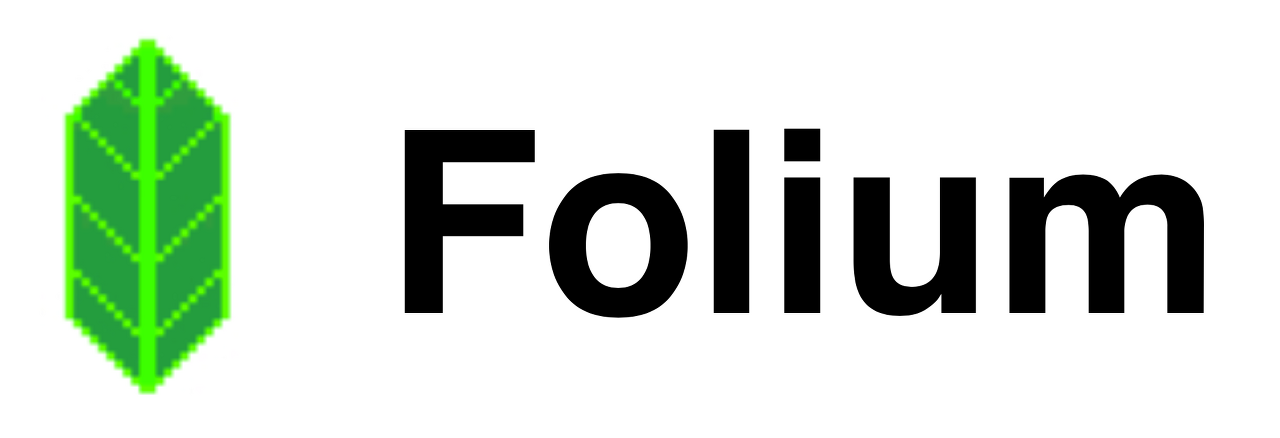

In [1]:
from collections import namedtuple
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import requests
import shelve

In [49]:
cg_coords = [-20.4640173,-54.6162947]

In [5]:
df = pd.read_csv('dados/casas_formatado.csv')

In [6]:
df.head()

,tipo,cidade/uf,bairro,endereço,área_total,área_construída,valor,suite,quarto,wc_social,vaga,asfalto,piscina
0,Casa-Térrea,Campo Grande - MS,Autonomista,R. Autonomista,216.21,118.00,690000.0,1,2,1,3,1,1
1,Casa-Térrea,Campo Grande - MS,Autonomista,R. Santa Bárbara,168.40,108.90,480000.0,1,2,1,2,1,0
2,Casa-Térrea,Campo Grande - MS,Carandá Bosque I,"R. Vitório Zeola, 922",1070.52,345.03,2500000.0,1,0,1,4,1,1
3,Casa-Térrea,Campo Grande - MS,Carandá Bosque I,NaN,360.00,210.00,1450000.0,3,0,0,3,0,0
4,Casa-Térrea,Campo Grande - MS,Centro,"R. Eduardo Santos Pereira, 332",640.00,361.00,1380000.0,1,2,1,3,0,0


In [32]:
df.shape

(5376, 13)

<span style="font-family: Arial Bold Italic; font-size: 20px"><a href="https://nominatim.openstreetmap.org/ui/search.html">Nominatim</a><span>

In [22]:
class ObtemCoords:
    def __init__(self):
        self.url = 'https://nominatim.openstreetmap.org/search.php'
        self.bairros_cords = {}
        self.coords = namedtuple('Coordenadas', 'lat long')
        
    def obtem_coords(self, bairro):
        params = {
            'q': f"{bairro.replace(' ', '+').lower()}+campo+grande+mato+grosso+do+sul+brasil",
            'format': 'jsonv2'
        }
        r = requests.get(self.url, params=params)
        r.raise_for_status()
        return r.json()

    def iniciar(self, bairros):
        for bairro in bairros:
            print(f'Obtendo dados do bairro: {bairro}')
            r_json = self.obtem_coords(bairro)
            if r_json:
                r_json = r_json[0]
                self.bairros_cords[bairro] = self.coords(lat=r_json['lat'], long=r_json['lon'])
            else:
                print(f'Coordenadas não encontradas para o bairro: {bairro}')

In [24]:
shelfFile = shelve.open('dados/coordenadas_bairro')
bairros_coords = shelfFile['coordenadas']
shelfFile.close()

In [28]:
bairros_coords = {k: np.array(v).astype(float) for k, v in bairros_coords.items()}

In [ ]:
bairros = df.bairro.unique()

obc = ObtemCoords()
obc.iniciar(bairros)

In [30]:
df2 = df[df.bairro.isin(
    np.intersect1d(df.bairro.values, np.array([key for key in bairros_coords.keys()]))
)].copy()

In [33]:
df2.shape

(4964, 13)

In [34]:
valor_medio = df2.iloc[:, [2, 6]].groupby(by='bairro')['valor'].mean().reset_index()

In [44]:
contagem = (
    df2.value_counts(subset='bairro')
    .reset_index()
    .rename(mapper={0: 'total'}, axis=1)
)

In [35]:
def format_num(num):
    i, f = str(num).split('.')
    i = format(int(i), ',d').replace(',', '.')
    return ','.join([i, f])

<span style="font-family: Arial Bold Italic; font-size: 20px"><a href="https://python-visualization.github.io/folium/">Folium</a></span>

In [47]:
m = folium.Map(location=[-20.4640173,-54.6162947], zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)

html = """
<h2>{}</h2>
<p>Preço médio das casas:</p>
<h3>{}</h3>
""".format


for row in valor_medio.itertuples(index=False):
    folium.Marker(
        location=[bairros_coords[row.bairro][0], bairros_coords[row.bairro][1]],
        popup=html(row.bairro, format_num(round(row.valor, 2))),
        icon=folium.Icon(color="blue", prefix='fa', icon="fa-home")
    ).add_to(marker_cluster)
    
m

<blockquote>
    <span style="font-family: Arial Bold Italic; font-size: 25px">HeatMap do Preço das Casas</span>
</blockquote>

In [50]:
data = [
    [bairros_coords[row.bairro][0], bairros_coords[row.bairro][1], round(row.valor, 2)]
    for row in valor_medio.itertuples(index=False)
]

m = folium.Map(location=cg_coords, zoom_start=12)

HeatMap(data).add_to(m)

m

<blockquote>
    <span style="font-family: Arial Bold Italic; font-size: 25px">HeatMap do Total de Casas a Venda em Cada Bairro</span>
</blockquote>

In [51]:
data = [
    [bairros_coords[row.bairro][0], bairros_coords[row.bairro][1], row.total]
    for row in contagem.itertuples(index=False)
]

m = folium.Map(location=cg_coords, zoom_start=12)

HeatMap(data).add_to(m)

m